In [3]:
pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   --------------------- ---------------- 524.3/920.8 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/920.8 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/920.8 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/920.8 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/920.8 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/920.8 kB 493.7 kB/s eta 0:00:01
   --------------------- ---------------- 524.3/920.8 kB 493.7 kB/s eta 0:00:01
   -------

Processing 2011 data with 11930 rows and 16 columns
Processing 2016 data with 11934 rows and 16 columns
Processing 2023 data with 11930 rows and 16 columns

Processing 2011 data:
Features shape: (8019, 32)
Silhouette score for 2 clusters: 0.1773
Silhouette score for 3 clusters: 0.1757
Silhouette score for 4 clusters: 0.1752
Silhouette score for 5 clusters: 0.1824
Optimal number of clusters: 5
Explained variance ratio: [0.22284859 0.19112599]
Applying t-SNE (this may take a few minutes)...
Applying Fuzzy C-means clustering...
Error applying fuzzy c-means: Unsupported dtype object
Using KMeans as a fallback
Analyzing cluster profiles...

K-means Cluster Profiles:
   cluster  size  percentage   age_mean  trip_duration_mean  \
0        0  1884   23.494201  30.425159           12.307164   
1        1  1964   24.491832  30.730143            9.171115   
2        2  2625   32.734755  30.393524           10.789699   
3        3   240    2.992892  33.825000           73.416147   
4        4  130

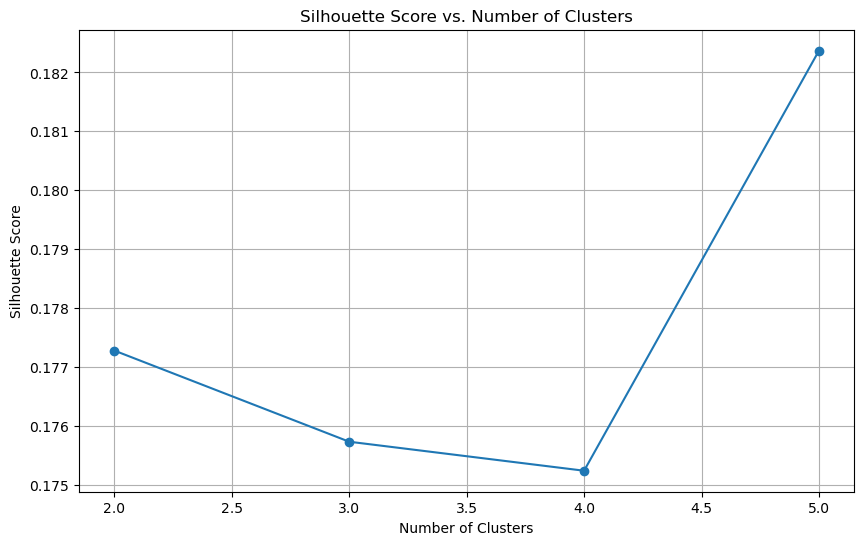

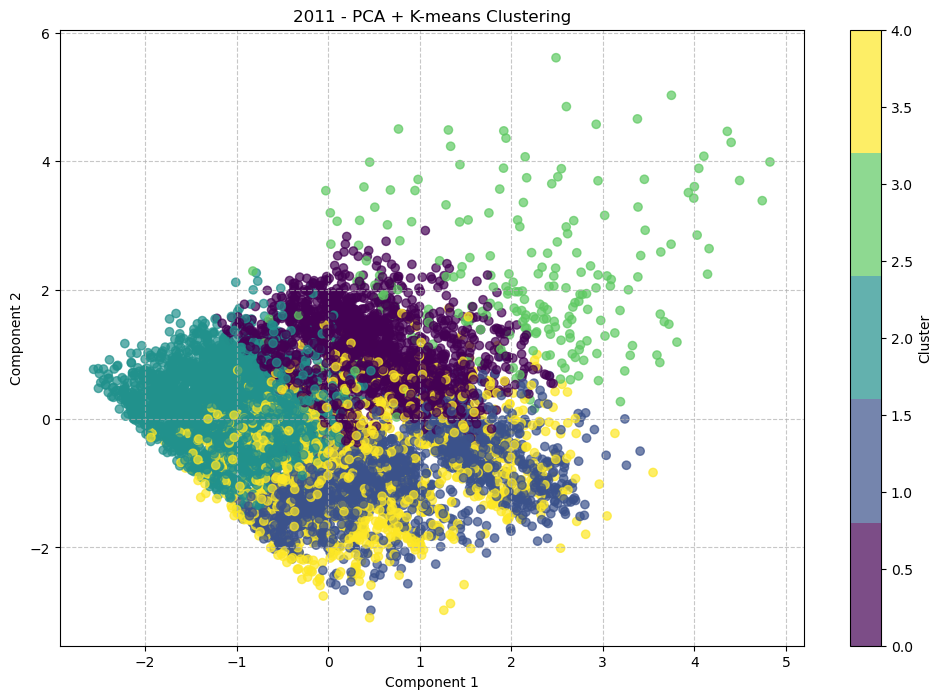

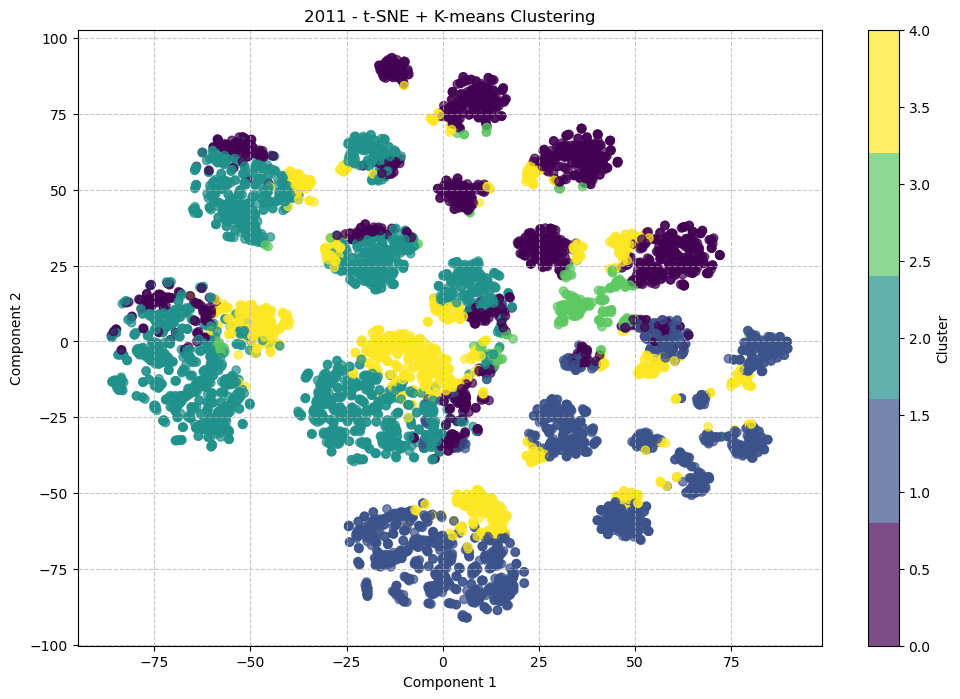

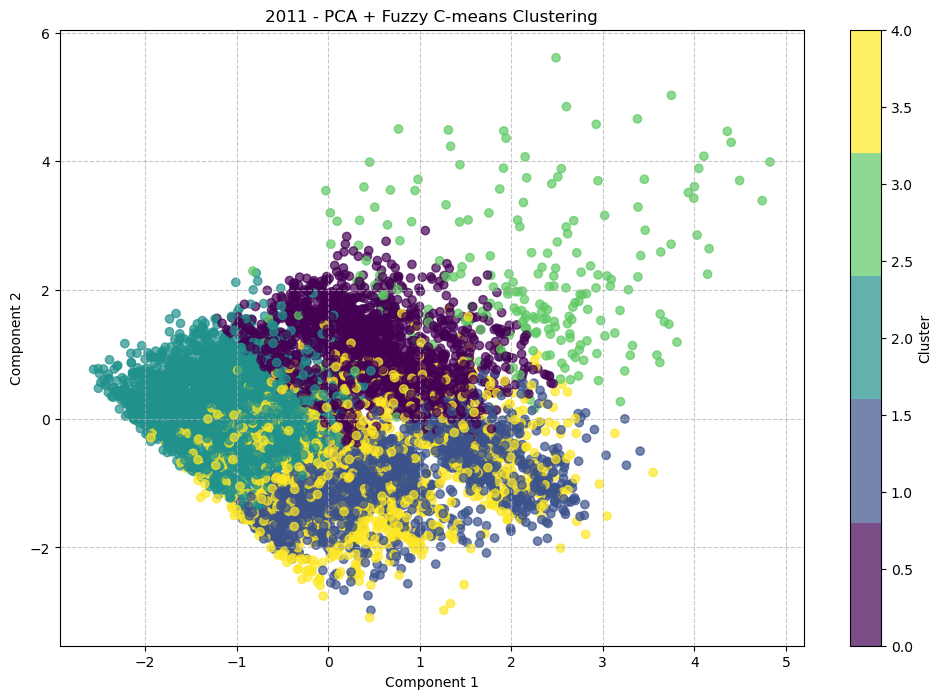

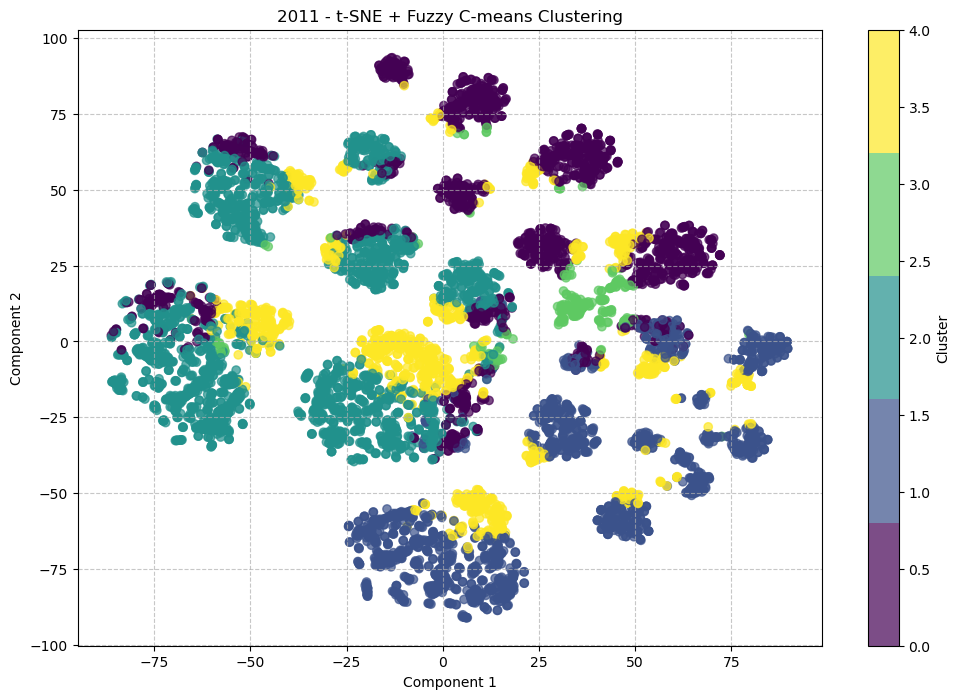

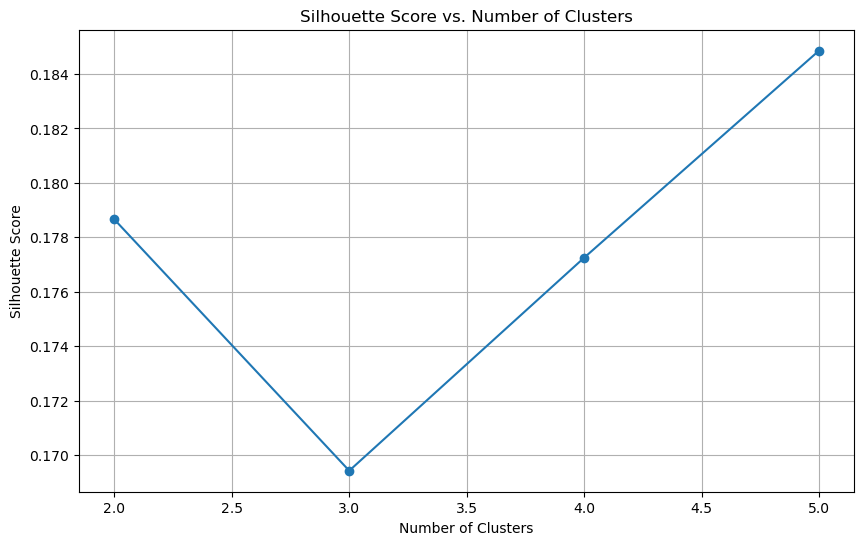

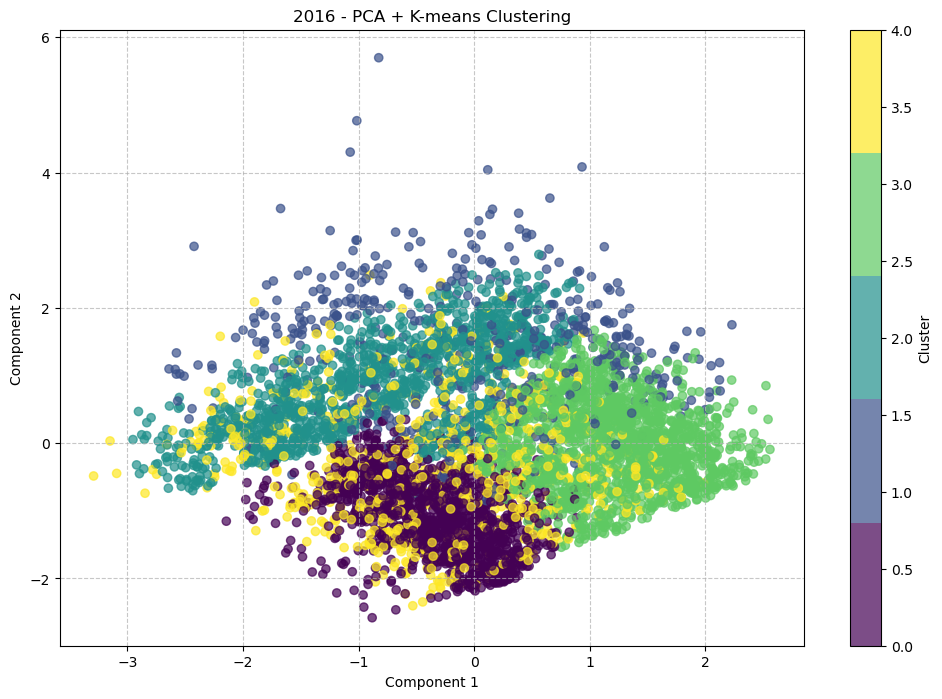

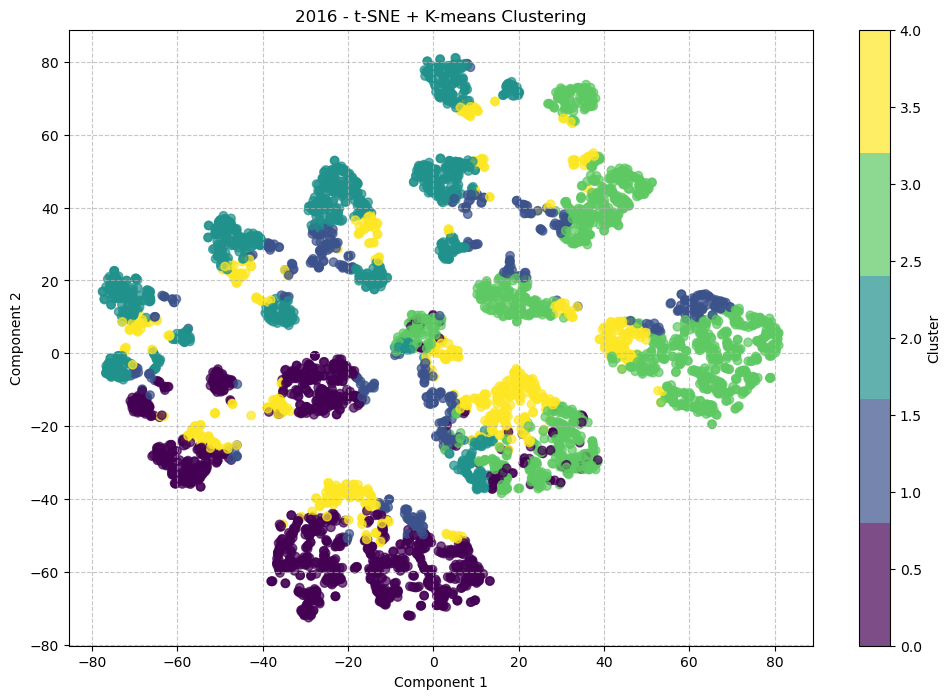

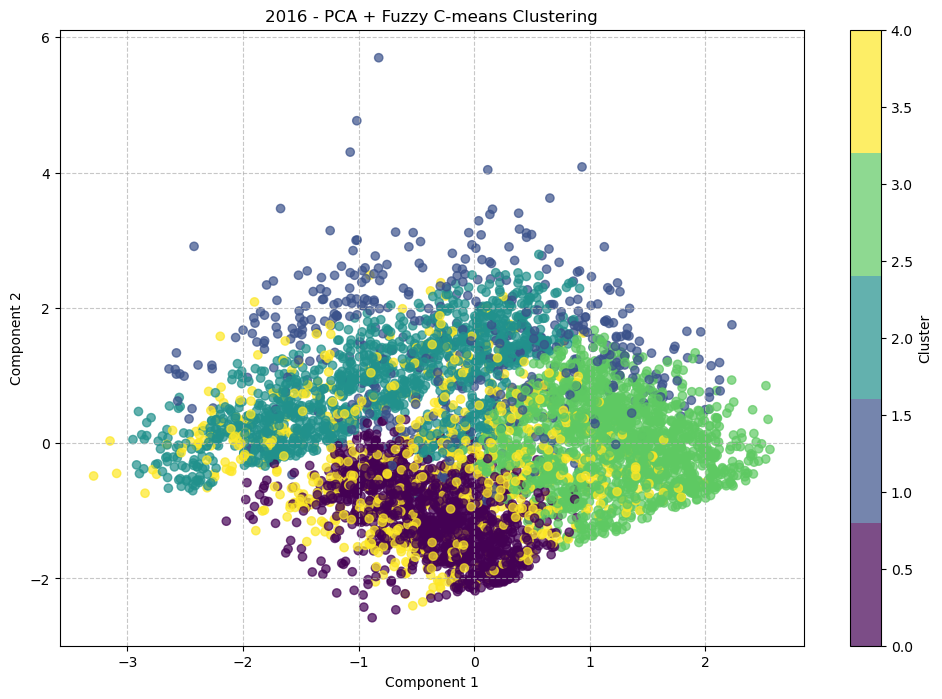

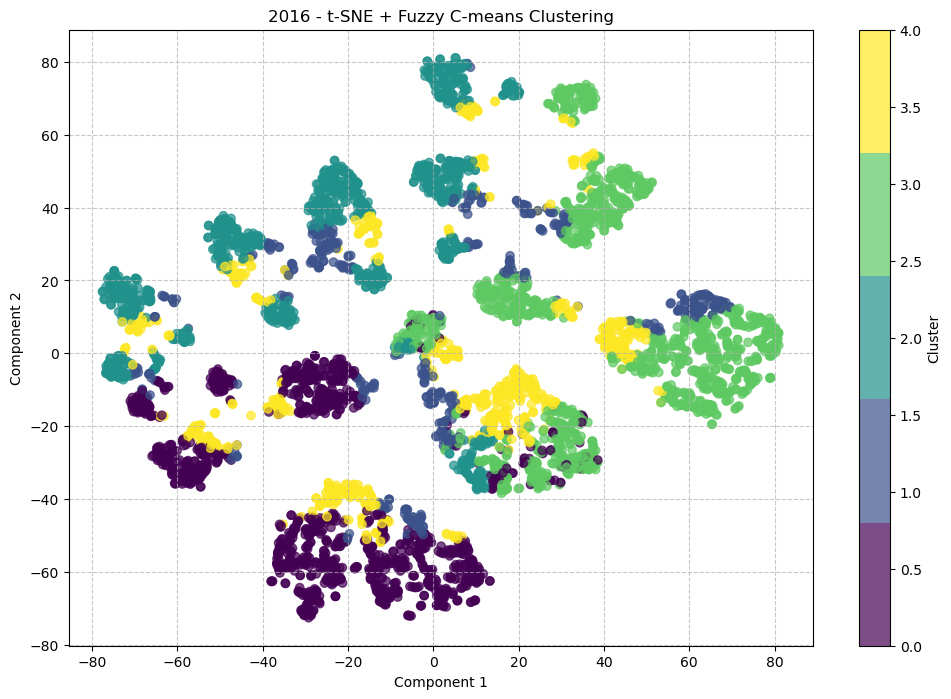

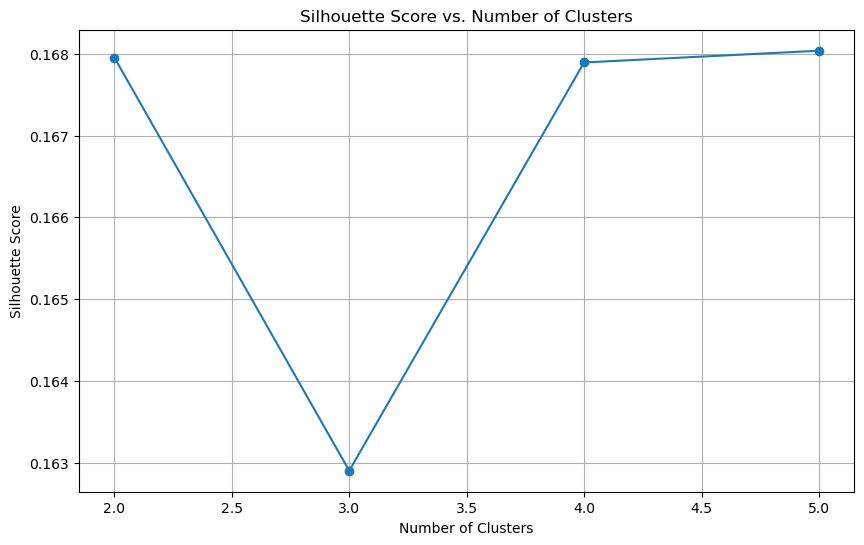

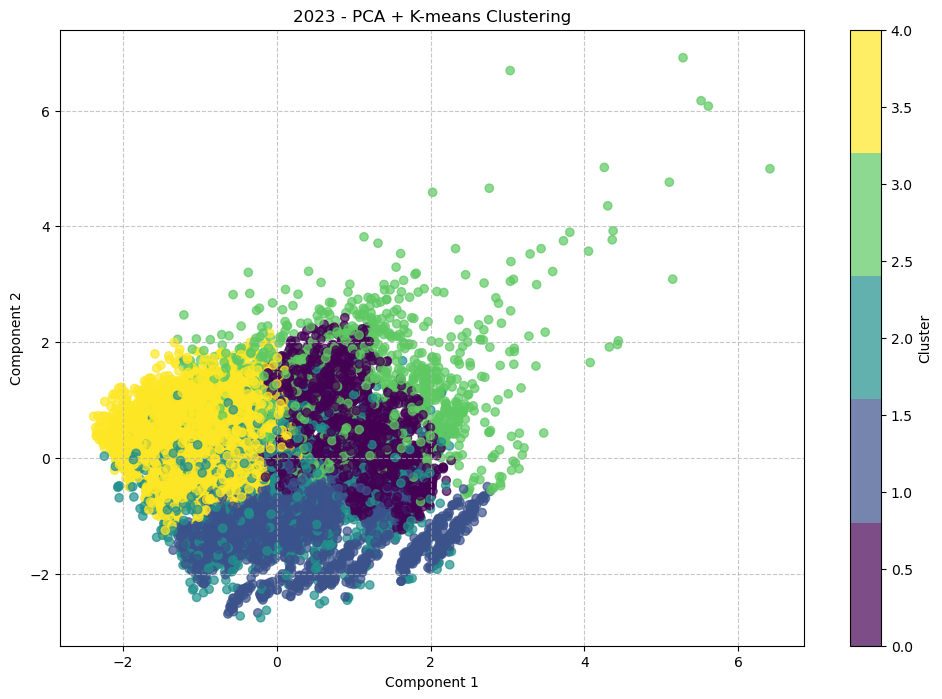

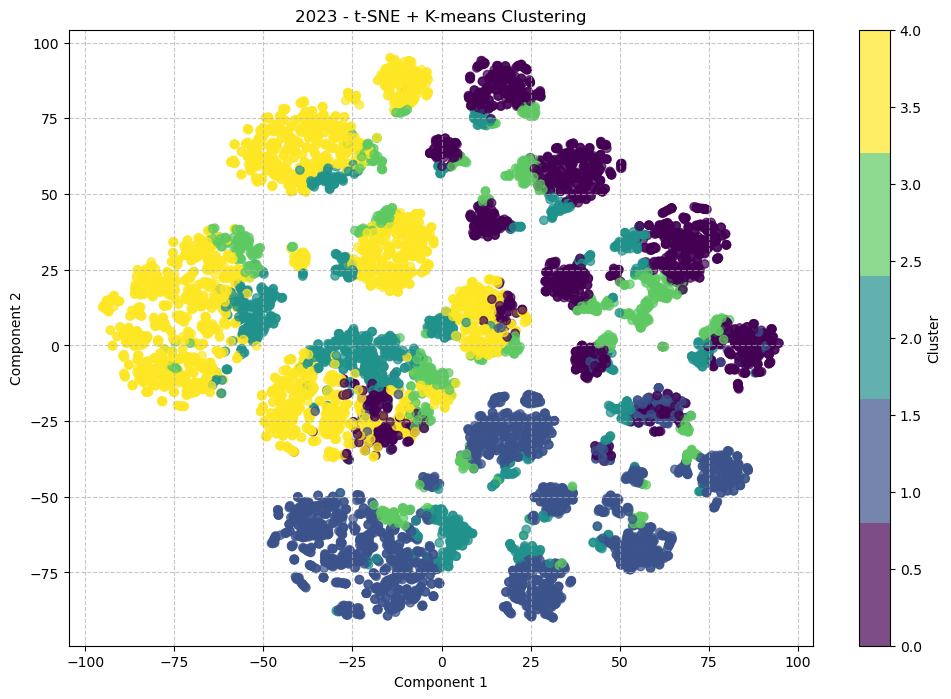

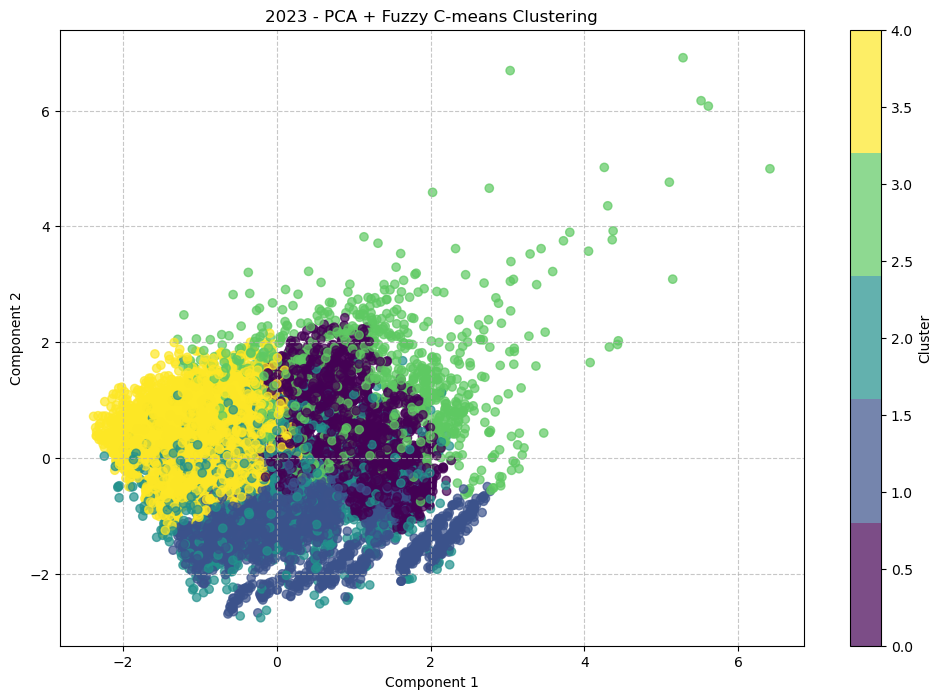

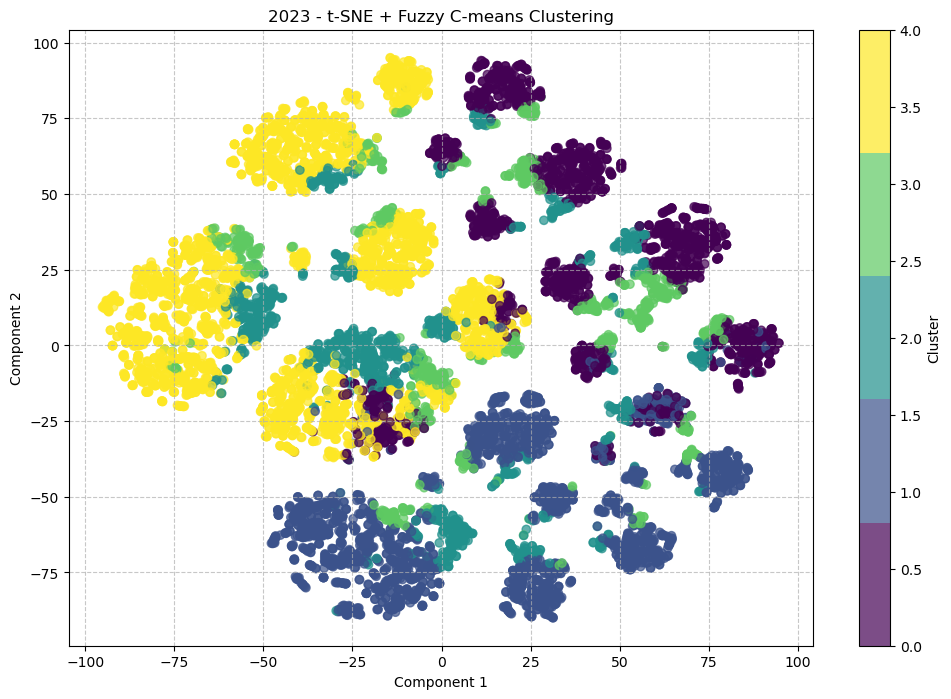

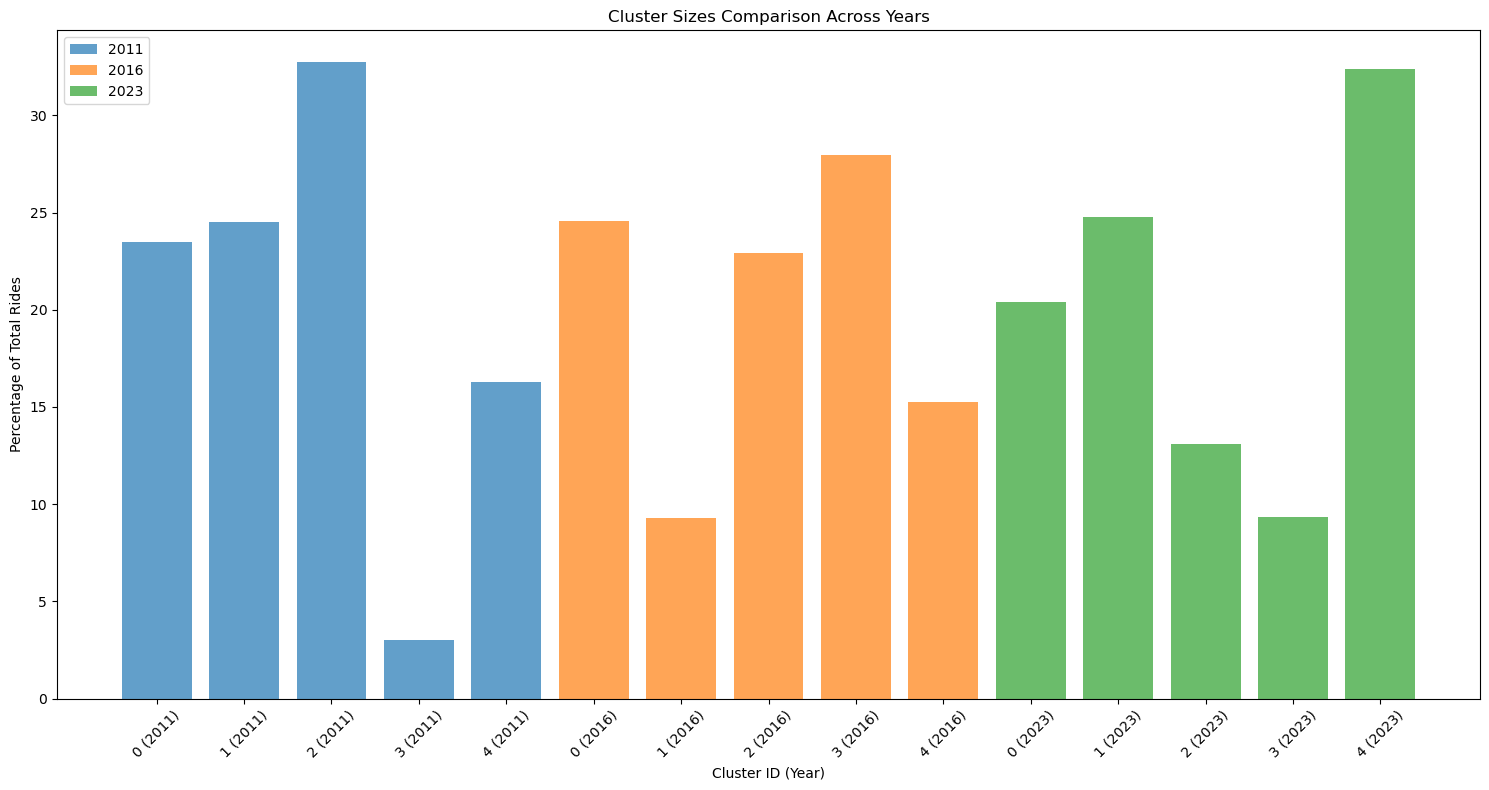

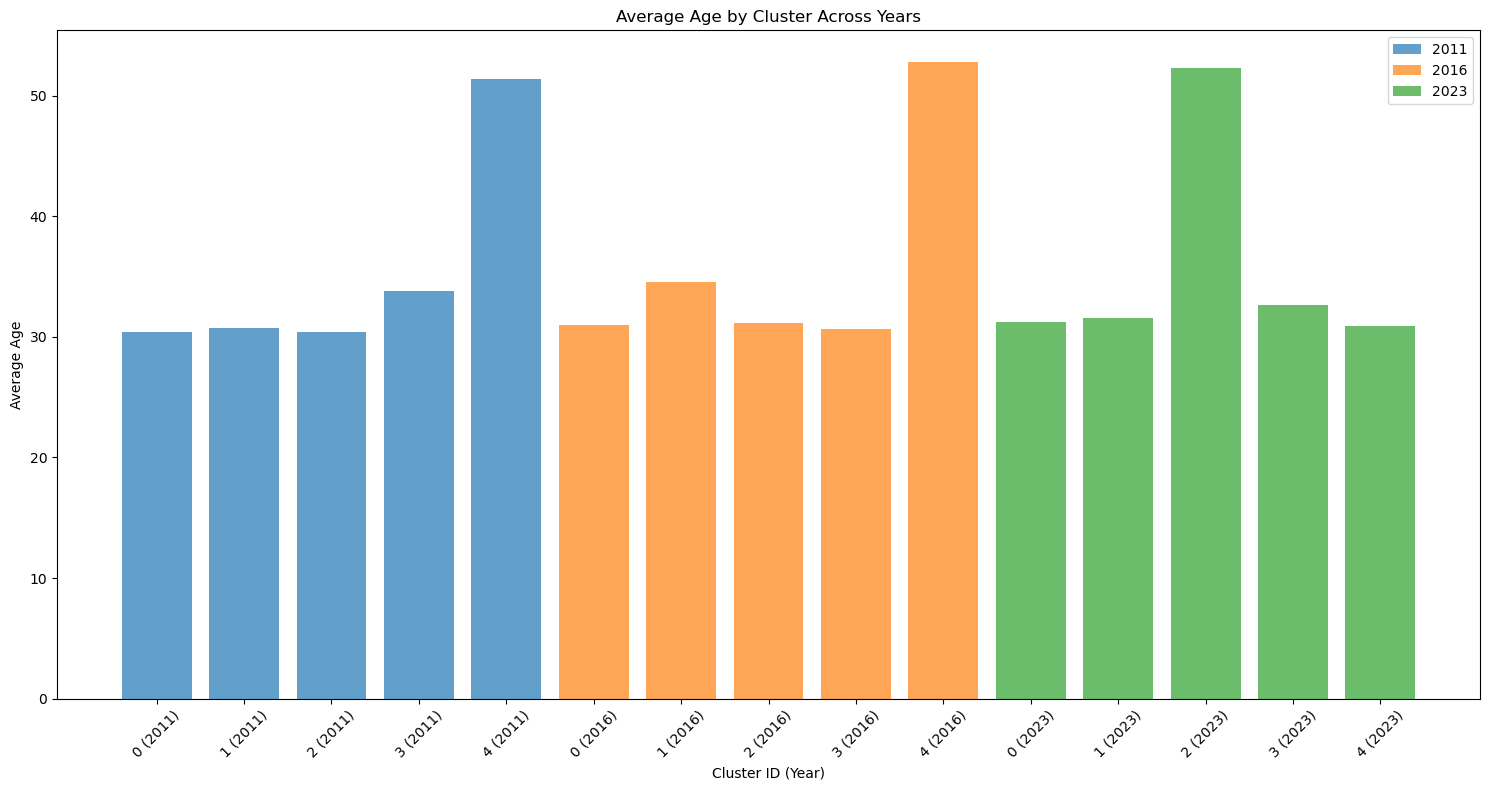

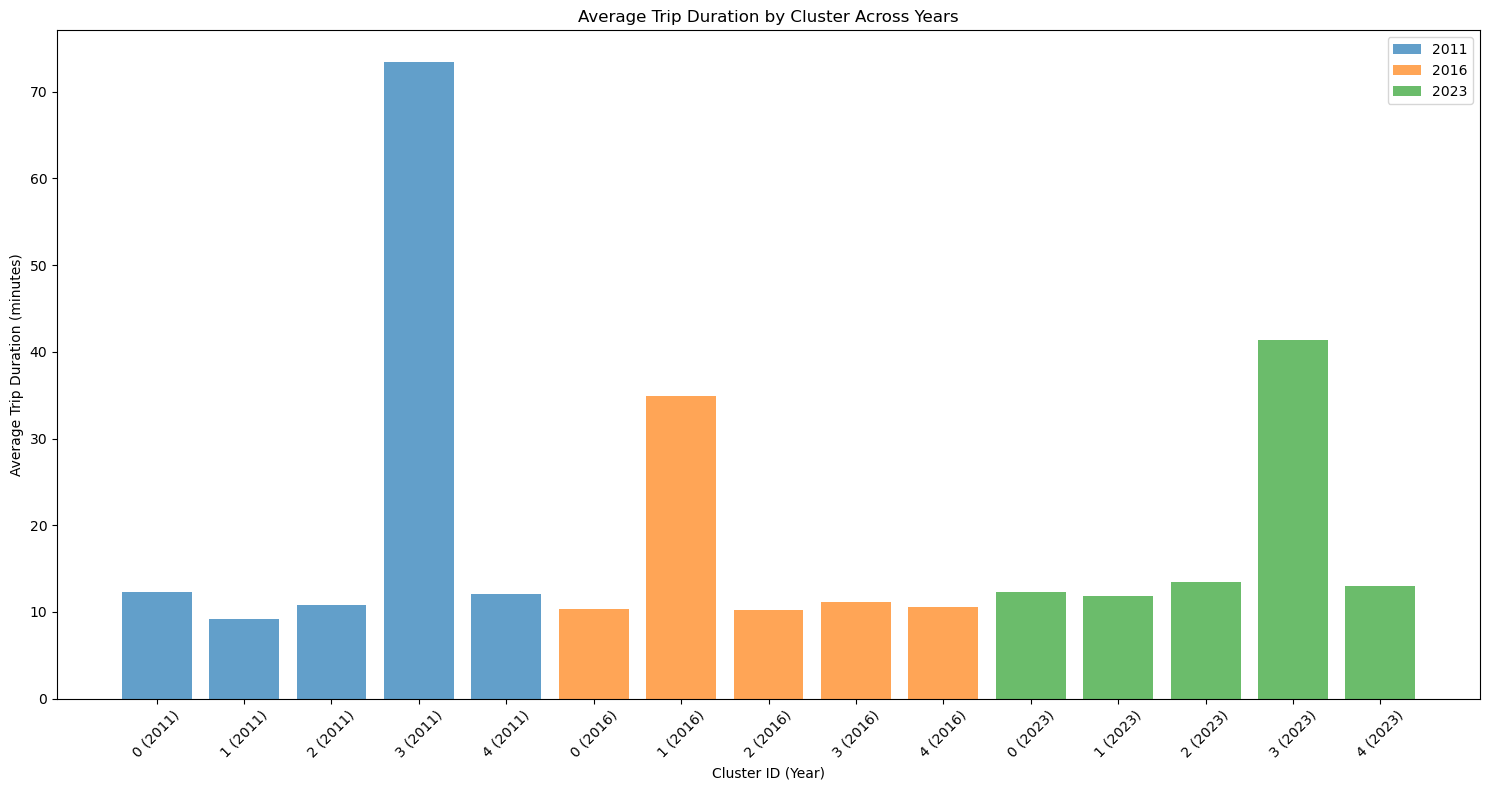

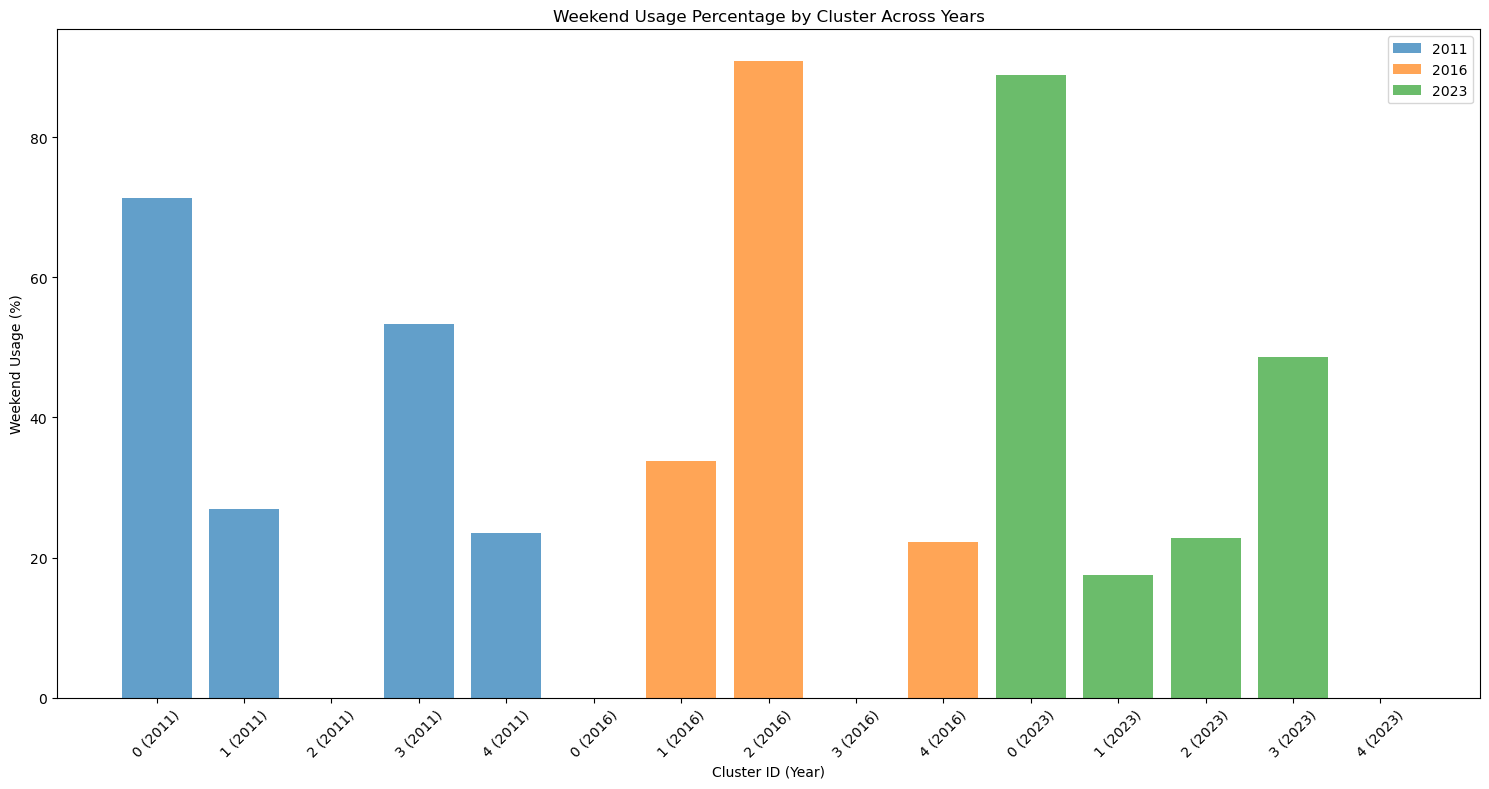

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import skfuzzy as fuzz
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

def load_and_preprocess(file_path):

    try:
        
        df = pd.read_csv(file_path)
        
        
        year = int(file_path.split('_')[1])
        
        print(f"Processing {year} data with {len(df)} rows and {len(df.columns)} columns")
        
         
        
        df['Edad_Usuario'] = pd.to_numeric(df['Edad_Usuario'], errors='coerce')
        
        
        df['Ciclo_Estacion_Retiro'] = df['Ciclo_Estacion_Retiro'].astype(str)
        df['Ciclo_Estacion_Arribo'] = df['Ciclo_Estacion_Arribo'].astype(str)
        
        
        df['fecha_hora_retiro'] = pd.to_datetime(df['Fecha_Retiro'] + ' ' + df['Hora_Retiro'], errors='coerce')
        df['fecha_hora_arribo'] = pd.to_datetime(df['Fecha_Arribo'] + ' ' + df['Hora_Arribo'], errors='coerce')
        
        
        df['duracion_viaje'] = (df['fecha_hora_arribo'] - df['fecha_hora_retiro']).dt.total_seconds() / 60
        
        
        df = df[(df['duracion_viaje'] > 0) & (df['duracion_viaje'] <= 180)]
        
        
        df['Genero_Usuario'].fillna('Unknown', inplace=True)
        df['Edad_Usuario'].fillna(df['Edad_Usuario'].median(), inplace=True)
        
        
        df['hour_of_day'] = pd.to_numeric(df['hour_of_day'], errors='coerce')
        df['day_of_week'] = pd.to_numeric(df['day_of_week'], errors='coerce')
        
        
        df['year'] = year
        
        return df
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to prepare features for clustering
def prepare_features(df):
    """
    Prepare features for clustering analysis.
    
    Args:
        df (pd.DataFrame): Input dataframe
        
    Returns:
        pd.DataFrame: Processed features for clustering
    """
    # Select features for clustering
    features = df[['Edad_Usuario', 'hour_of_day', 'day_of_week', 'is_weekend', 'duracion_viaje']].copy()
    
    # Add gender as categorical feature (one-hot encoding)
    gender_dummies = pd.get_dummies(df['Genero_Usuario'], prefix='gender')
    features = pd.concat([features, gender_dummies], axis=1)
    
    # Add time period as categorical feature (one-hot encoding)
    time_period_dummies = pd.get_dummies(df['time_period'], prefix='time')
    features = pd.concat([features, time_period_dummies], axis=1)
    
    # Create features for popular stations
    pickup_station_counts = df['Ciclo_Estacion_Retiro'].value_counts().nlargest(10)
    dropoff_station_counts = df['Ciclo_Estacion_Arribo'].value_counts().nlargest(10)
    
    # Create dummy variables for top pickup stations
    for station in pickup_station_counts.index:
        features[f'pickup_{station}'] = (df['Ciclo_Estacion_Retiro'] == station).astype(int)
    
    # Create dummy variables for top dropoff stations
    for station in dropoff_station_counts.index:
        features[f'dropoff_{station}'] = (df['Ciclo_Estacion_Arribo'] == station).astype(int)
    
    # Handle missing values
    features = features.fillna(features.median())
    
    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = ['Edad_Usuario', 'hour_of_day', 'day_of_week', 'duracion_viaje']
    features[numerical_cols] = scaler.fit_transform(features[numerical_cols])
    
    return features


def find_optimal_clusters(features, max_clusters=5):
    silhouette_scores = []
    
    
    for n_clusters in range(2, max_clusters + 1):
        try:
            kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
            cluster_labels = kmeans.fit_predict(features)
            
            
            score = silhouette_score(features, cluster_labels)
            silhouette_scores.append((n_clusters, score))
            print(f"Silhouette score for {n_clusters} clusters: {score:.4f}")
        except Exception as e:
            print(f"Error calculating silhouette score for {n_clusters} clusters: {e}")
    
    if not silhouette_scores:
        print("Could not calculate silhouette scores. Using default value of 3 clusters.")
        return 3
    
    # Find the number of clusters with the highest silhouette score
    optimal_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"Optimal number of clusters: {optimal_clusters}")
    
    
    plt.figure(figsize=(10, 6))
    plt.plot([x[0] for x in silhouette_scores], [x[1] for x in silhouette_scores], 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.grid(True)
    
    return optimal_clusters

# Function to perform PCA dimensionality reduction
def apply_pca(features, n_components=2):

    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    pca_result = pca.fit_transform(features)
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pca_result, pca

# Function to perform t-SNE dimensionality reduction
def apply_tsne(features, perplexity=30, n_components=2):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=RANDOM_STATE)
    tsne_result = tsne.fit_transform(features)
    return tsne_result

# Function to perform fuzzy c-means clustering
def apply_fuzzy_cmeans(features, n_clusters, m=2):
    try:
        # Convert DataFrame to numpy array if needed
        if isinstance(features, pd.DataFrame):
            features_array = features.values
        else:
            features_array = features
        
        # Reshape for fcm which expects (features, samples)
        fcm_data = features_array.T
        
        # Apply fuzzy c-means
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            fcm_data, 
            c=n_clusters, 
            m=m, 
            error=0.005, 
            maxiter=1000, 
            init=None
        )
        
        # Get cluster membership for each sample
        cluster_membership = np.argmax(u, axis=0)
        
        print(f"Fuzzy C-means clustering completed. Partition coefficient: {fpc}")
        return cluster_membership, u
    
    except Exception as e:
        print(f"Error applying fuzzy c-means: {e}")
        print("Using KMeans as a fallback")
        
        # Use KMeans as a fallback
        kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
        labels = kmeans.fit_predict(features)
        
        # Create a dummy membership matrix (not real fuzzy membership)
        u = np.zeros((n_clusters, len(labels)))
        for i, label in enumerate(labels):
            u[label, i] = 1
        
        return labels, u


def visualize_clusters(data, labels, title, xlabel='Component 1', ylabel='Component 2'):
    plt.figure(figsize=(12, 8))
    
    
    n_clusters = len(np.unique(labels))
    cmap = plt.cm.get_cmap('viridis', n_clusters)
    
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap, alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    return plt.gcf()


def analyze_clusters(df, cluster_labels):
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Calculate cluster size
    cluster_sizes = df_clustered['cluster'].value_counts().to_dict()
    
    cluster_profiles = []
    
    for cluster_id in sorted(np.unique(cluster_labels)):
        cluster_df = df_clustered[df_clustered['cluster'] == cluster_id]
        
        profile = {
            'cluster': cluster_id,
            'size': len(cluster_df),
            'percentage': len(cluster_df) / len(df_clustered) * 100,
            'age_mean': cluster_df['Edad_Usuario'].mean(),
            'trip_duration_mean': cluster_df['duracion_viaje'].mean(),
            'hour_of_day_mean': cluster_df['hour_of_day'].mean(),
            'weekend_percentage': cluster_df['is_weekend'].mean() * 100,
            'top_gender': cluster_df['Genero_Usuario'].value_counts().index[0],
            'top_time_period': cluster_df['time_period'].value_counts().index[0],
            'top_pickup_station': cluster_df['Ciclo_Estacion_Retiro'].value_counts().index[0],
            'top_dropoff_station': cluster_df['Ciclo_Estacion_Arribo'].value_counts().index[0]
        }
        
        cluster_profiles.append(profile)
    
    return pd.DataFrame(cluster_profiles)

# Function to create cluster comparison visualizations
def visualize_cluster_comparisons(results, years):
    plt.figure(figsize=(15, 8))
    
    for i, year in enumerate(years):
        cluster_sizes = results[i]['kmeans_profile'][['cluster', 'percentage']]
        plt.bar(
            [str(c) + f" ({year})" for c in cluster_sizes['cluster']], 
            cluster_sizes['percentage'],
            alpha=0.7,
            label=str(year)
        )
    
    plt.title('Cluster Sizes Comparison Across Years')
    plt.xlabel('Cluster ID (Year)')
    plt.ylabel('Percentage of Total Rides')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    
    plt.figure(figsize=(15, 8))
    
    for i, year in enumerate(years):
        age_by_cluster = results[i]['kmeans_profile'][['cluster', 'age_mean']]
        plt.bar(
            [str(c) + f" ({year})" for c in age_by_cluster['cluster']], 
            age_by_cluster['age_mean'],
            alpha=0.7,
            label=str(year)
        )
    
    plt.title('Average Age by Cluster Across Years')
    plt.xlabel('Cluster ID (Year)')
    plt.ylabel('Average Age')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    
    plt.figure(figsize=(15, 8))
    
    for i, year in enumerate(years):
        duration_by_cluster = results[i]['kmeans_profile'][['cluster', 'trip_duration_mean']]
        plt.bar(
            [str(c) + f" ({year})" for c in duration_by_cluster['cluster']], 
            duration_by_cluster['trip_duration_mean'],
            alpha=0.7,
            label=str(year)
        )
    
    plt.title('Average Trip Duration by Cluster Across Years')
    plt.xlabel('Cluster ID (Year)')
    plt.ylabel('Average Trip Duration (minutes)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 4. Weekend usage by cluster and year
    plt.figure(figsize=(15, 8))
    
    for i, year in enumerate(years):
        weekend_by_cluster = results[i]['kmeans_profile'][['cluster', 'weekend_percentage']]
        plt.bar(
            [str(c) + f" ({year})" for c in weekend_by_cluster['cluster']], 
            weekend_by_cluster['weekend_percentage'],
            alpha=0.7,
            label=str(year)
        )
    
    plt.title('Weekend Usage Percentage by Cluster Across Years')
    plt.xlabel('Cluster ID (Year)')
    plt.ylabel('Weekend Usage (%)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()


def analyze_bicycle_usage(file_paths, years):
    results = []
    
    dfs = []
    for file_path in file_paths:
        df = load_and_preprocess(file_path)
        if df is not None:
            dfs.append(df)
    
    if len(dfs) != len(years):
        print("Warning: Not all data files were loaded successfully!")
    
    for i, (df, year) in enumerate(zip(dfs, years)):
        print(f"\n{'='*50}")
        print(f"Processing {year} data:")
        print(f"{'='*50}")
        

        features = prepare_features(df)
        print(f"Features shape: {features.shape}")
        

        n_clusters = find_optimal_clusters(features)
        

        pca_result, pca = apply_pca(features)
        

        print("Applying t-SNE (this may take a few minutes)...")
        tsne_result = apply_tsne(features)
        
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
        kmeans_labels = kmeans.fit_predict(features)
        
        # Apply Fuzzy C-means clustering
        print("Applying Fuzzy C-means clustering...")
        fuzzy_labels, membership = apply_fuzzy_cmeans(features, n_clusters)
        
        # Visualize PCA + K-means
        pca_kmeans_fig = visualize_clusters(
            pca_result, 
            kmeans_labels, 
            f'{year} - PCA + K-means Clustering'
        )
        
        # Visualize t-SNE + K-means
        tsne_kmeans_fig = visualize_clusters(
            tsne_result, 
            kmeans_labels, 
            f'{year} - t-SNE + K-means Clustering'
        )
        
        # Visualize PCA + Fuzzy C-means
        pca_fuzzy_fig = visualize_clusters(
            pca_result, 
            fuzzy_labels, 
            f'{year} - PCA + Fuzzy C-means Clustering'
        )
        
        # Visualize t-SNE + Fuzzy C-means
        tsne_fuzzy_fig = visualize_clusters(
            tsne_result, 
            fuzzy_labels, 
            f'{year} - t-SNE + Fuzzy C-means Clustering'
        )
        
        
        print("Analyzing cluster profiles...")
        kmeans_profile = analyze_clusters(df, kmeans_labels)
        fuzzy_profile = analyze_clusters(df, fuzzy_labels)
        
        
        results.append({
            'year': year,
            'df': df,
            'features': features,
            'n_clusters': n_clusters,
            'pca_result': pca_result,
            'tsne_result': tsne_result,
            'kmeans_labels': kmeans_labels,
            'fuzzy_labels': fuzzy_labels,
            'kmeans_profile': kmeans_profile,
            'fuzzy_profile': fuzzy_profile,
            'pca_kmeans_fig': pca_kmeans_fig,
            'tsne_kmeans_fig': tsne_kmeans_fig,
            'pca_fuzzy_fig': pca_fuzzy_fig,
            'tsne_fuzzy_fig': tsne_fuzzy_fig
        })
        
        
        print("\nK-means Cluster Profiles:")
        print(kmeans_profile[['cluster', 'size', 'percentage', 'age_mean', 'trip_duration_mean', 
                              'weekend_percentage', 'top_gender', 'top_time_period']])
        
        print("\nFuzzy C-means Cluster Profiles:")
        print(fuzzy_profile[['cluster', 'size', 'percentage', 'age_mean', 'trip_duration_mean',
                            'weekend_percentage', 'top_gender', 'top_time_period']])
    
    
    visualize_cluster_comparisons(results, years)
    
    
    print("\nSummary of Cluster Changes Across Years:")
    print("-" * 50)
    
    
    for i, year in enumerate(years):
        if i > 0:
            prev_year = years[i-1]
            curr_year = year
            
            print(f"\nChanges from {prev_year} to {curr_year}:")
            
            prev_kmeans_profile = results[i-1]['kmeans_profile']
            curr_kmeans_profile = results[i]['kmeans_profile']
            
            
            prev_n_clusters = results[i-1]['n_clusters']
            curr_n_clusters = results[i]['n_clusters']
            
            print(f"Number of clusters: {prev_n_clusters} -> {curr_n_clusters}")
            
            
            if prev_n_clusters == curr_n_clusters:
                for cluster in range(prev_n_clusters):
                    prev_cluster = prev_kmeans_profile[prev_kmeans_profile['cluster'] == cluster].iloc[0]
                    curr_cluster = curr_kmeans_profile[curr_kmeans_profile['cluster'] == cluster].iloc[0]
                    
                    print(f"\nCluster {cluster}:")
                    print(f"  Size: {prev_cluster['percentage']:.1f}% -> {curr_cluster['percentage']:.1f}%")
                    print(f"  Age: {prev_cluster['age_mean']:.1f} -> {curr_cluster['age_mean']:.1f}")
                    print(f"  Trip duration: {prev_cluster['trip_duration_mean']:.1f} -> {curr_cluster['trip_duration_mean']:.1f} minutes")
                    print(f"  Weekend usage: {prev_cluster['weekend_percentage']:.1f}% -> {curr_cluster['weekend_percentage']:.1f}%")
                    print(f"  Top gender: {prev_cluster['top_gender']} -> {curr_cluster['top_gender']}")
                    print(f"  Top time period: {prev_cluster['top_time_period']} -> {curr_cluster['top_time_period']}")
            else:
                print("Number of clusters changed, so direct cluster-to-cluster comparison is not possible.")
    
    return results


file_paths = [
    'ecobici_2011_muestra.csv',
    'ecobici_2016_muestra.csv',
    'ecobici_2023_muestra.csv'
]
years = [2011, 2016, 2023]


if __name__ == "__main__":
    results = analyze_bicycle_usage(file_paths, years)
    plt.tight_layout()
    plt.show()